In [1]:
%cd ../

/Users/rohan/repositories/final/clip-feat-vis


In [2]:
import os
import sys

cwd = os.getcwd()
sys.path.append(os.path.join(cwd, "faceted_visualization"))
sys.path.append(os.path.join(cwd, "faceted_visualization", "visualizer"))

In [3]:
import faceted_visualization.visualizer.main
import faceted_visualization.visualizer.render
import faceted_visualization.visualizer.hook
import faceted_visualization.visualizer.image
import faceted_visualization.visualizer.helpers
import faceted_visualization.visualizer.wb
import faceted_visualization.visualizer.constants as constants
import wandb
import pprint
import clip
import os
import logging
import datetime
import torch

In [4]:
logging.basicConfig(force=True, level="INFO",
                    format="%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s")
logger = logging.getLogger()
init_stream = True
for handler in logger.handlers:
    if isinstance(handler, logging.StreamHandler):
        init_stream = False
if init_stream:
    consoleHandler = logging.StreamHandler(sys.stdout)
    logger.addHandler(consoleHandler)

# Generate Random Seed

In [5]:
generated_random_seed = faceted_visualization.visualizer.helpers.random_seed(8)
logger.info("Seed = %s", generated_random_seed)

2023-12-13 21:55:18,087 [MainThread  ] [INFO ]  Seed = 27528559


# Define Hyperparameters

In [6]:
config = {
    constants.NUMBER_OF_ITERATIONS: 512,
    constants.MODEL: "RN50x4",
    constants.PATH_LINEAR_PROBE: "notebooks/sample_probe_weights.pth",
    constants.LINEAR_PROBE_LAYER: 'layer3_9_relu3',
    constants.VISUALIZATION_LAYER:  'layer4_5_relu3',
    constants.OPTIMIZER: "AdamW",
    constants.LEARNING_RATE: 0.05,
    constants.CHANNEL: 1000,
    constants.OBJECTIVE: "neuron",
    constants.USE_TRANSFORMS: True,
    constants.USE_STD_TRANSFORMS: True,
    constants.RANDOM_SEED: generated_random_seed
}
logger.info("Sweep Configuration = \n %s", pprint.pformat(config))

2023-12-13 21:55:18,091 [MainThread  ] [INFO ]  Sweep Configuration = 
 {'channel': 1000,
 'learning_rate': 0.05,
 'linear_probe_directory': 'notebooks/sample_probe_weights.pth',
 'linear_probe_layer': 'layer3_9_relu3',
 'model': 'RN50x4',
 'num_iterations': 512,
 'objective': 'neuron',
 'optimizer': 'AdamW',
 'random_seed': 27528559,
 'use_std_transforms': True,
 'use_transforms': True,
 'visualization_layer': 'layer4_5_relu3'}


In [7]:
if torch.cuda.is_available():
    DEVICE = "cuda:0"
else:
    DEVICE = "cpu"
logger.info("Selected Device = %s", DEVICE)

2023-12-13 21:55:18,094 [MainThread  ] [INFO ]  Selected Device = cpu


# Initialize Random Seed

In [8]:
faceted_visualization.visualizer.helpers.set_seed(config[constants.RANDOM_SEED])

2023-12-13 21:55:18,096 [MainThread  ] [INFO ]  Setting random seed to 27528559


27528559

# Load CLIP Model

In [9]:
model, clip_transforms = faceted_visualization.visualizer.main.get_model(config[constants.MODEL], device=DEVICE)

2023-12-13 21:55:18,102 [MainThread  ] [INFO ]  Loading CLIP model [ RN50x4 ].
2023-12-13 21:55:22,054 [MainThread  ] [INFO ]  Finished loading model [ RN50x4 ]
2023-12-13 21:55:22,055 [MainThread  ] [INFO ]  Finished loading transforms [ Compose(
    Resize(size=288, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(288, 288))
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
) ]


# Hook Model 
Provides a handle to all the layers of the model so that we can retrieve the inputs and outputs at every (intermediate) point in the model

In [10]:
model_hook = faceted_visualization.visualizer.hook.register_hooks(model)

2023-12-13 21:55:22,059 [MainThread  ] [INFO ]  Registering hooks.
2023-12-13 21:55:22,061 [MainThread  ] [INFO ]  Finished registering hooks.


# Generate Randomly Initialized Image and Corresponding Parameters

In [11]:
params, image_f = faceted_visualization.visualizer.image.generate_img(h=288, w=288,
                                                                              decorrelate=True,
                                                                              fft=True,
                                                                              device=DEVICE)

# Load weights from Linear Probe

In [12]:
probe_weights = faceted_visualization.visualizer.main.get_probe_weights(model_location=os.path.join(os.getcwd(), config[constants.PATH_LINEAR_PROBE]),
                                                                        device=DEVICE)

2023-12-13 21:55:22,072 [MainThread  ] [INFO ]  Retrieving weights of linear probe [ path = /Users/rohan/repositories/final/clip-feat-vis/notebooks/sample_probe_weights.pth ]


# Define Optimizer

In [13]:
optimizer = faceted_visualization.visualizer.main.get_optimizer(
    parameters=params,
    learning_rate=config[constants.LEARNING_RATE],
    optimizer_name=config[constants.OPTIMIZER]
)

2023-12-13 21:55:22,077 [MainThread  ] [INFO ]  Creating AdamW optimizer with params [ lr = 0.05000 ]


# Consolidate Image Augmentations

In [14]:
transforms = faceted_visualization.visualizer.image.consolidate_transforms(
            use_clip_transforms=config[constants.USE_TRANSFORMS],
            use_standard_transforms=config[constants.USE_STD_TRANSFORMS],
            clip_transforms=clip_transforms
        )

In [15]:
logger.info("Final list of transforms = %s", transforms.transforms if transforms is not None else "NA")

2023-12-13 21:55:22,085 [MainThread  ] [INFO ]  Final list of transforms = [Resize(size=288, interpolation=bicubic, max_size=None, antialias=warn), CenterCrop(size=(288, 288)), Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)), RandomAffine(degrees=[0.0, 0.0], translate=(0.03, 0.03), interpolation=InterpolationMode.NEAREST, fill=0), RandomAffine(degrees=[0.0, 0.0], scale=(0.9, 1.1), interpolation=InterpolationMode.NEAREST, fill=0), RandomRotation(degrees=[-10.0, 10.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0), RandomAffine(degrees=[0.0, 0.0], translate=(0.015, 0.015), interpolation=InterpolationMode.NEAREST, fill=0)]


# Run Optimization

In [16]:
faceted_visualization.visualizer.render.optimize(
            num_iterations=config[constants.NUMBER_OF_ITERATIONS],
            transforms=transforms,
            image_function=image_f,
            model=model,
            channel=config[constants.CHANNEL],
            objective=config[constants.OBJECTIVE],
            layer=config[constants.VISUALIZATION_LAYER],
            linear_probe_layer=config[constants.LINEAR_PROBE_LAYER],
            probe_weights=probe_weights,
            optimizer=optimizer,
            model_hook=model_hook,
            neuron_x=config.get(constants.NEURON_X, None),
            neuron_y=config.get(constants.NEURON_Y, None),
            wandb_object=faceted_visualization.visualizer.wb.WandB(enabled=False, api_key=None, entity=None, run_name=None, project=None, config=None),
            run_id=generated_random_seed,
            device=DEVICE,
            image_name="Sample"
            )

2023-12-13 21:55:22,089 [MainThread  ] [INFO ]  Starting optimization process [ run_id = 27528559 ]...
2023-12-13 21:55:22,515 [MainThread  ] [INFO ]  Epoch: 1/512: Loss = -99.9549561 :: Learning Rate = 0.0500000
2023-12-13 21:55:51,766 [MainThread  ] [INFO ]  Epoch: 101/512: Loss = -100.4123230 :: Learning Rate = 0.0500000
2023-12-13 21:56:20,980 [MainThread  ] [INFO ]  Epoch: 201/512: Loss = 82.6337814 :: Learning Rate = 0.0500000
2023-12-13 21:56:50,098 [MainThread  ] [INFO ]  Epoch: 301/512: Loss = -67.8692169 :: Learning Rate = 0.0500000
2023-12-13 21:57:19,058 [MainThread  ] [INFO ]  Epoch: 401/512: Loss = -132.8163452 :: Learning Rate = 0.0500000
2023-12-13 21:57:48,157 [MainThread  ] [INFO ]  Epoch: 501/512: Loss = -62.1498604 :: Learning Rate = 0.0500000
2023-12-13 21:57:51,343 [MainThread  ] [INFO ]  Epoch: 512/512: Loss = 14.5898323 :: Learning Rate = 0.0500000


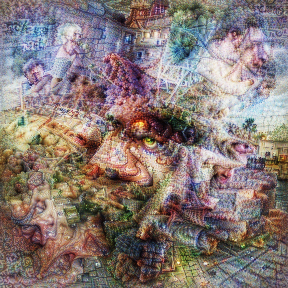

In [17]:
display(faceted_visualization.visualizer.image.convert_to_PIL(image_f()))